<a href="https://colab.research.google.com/github/Sajad-Adil/Time-Series-Classification-using-Machine-Learning-on-EEG-Data/blob/main/EEG_Classification_using_Transfer_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

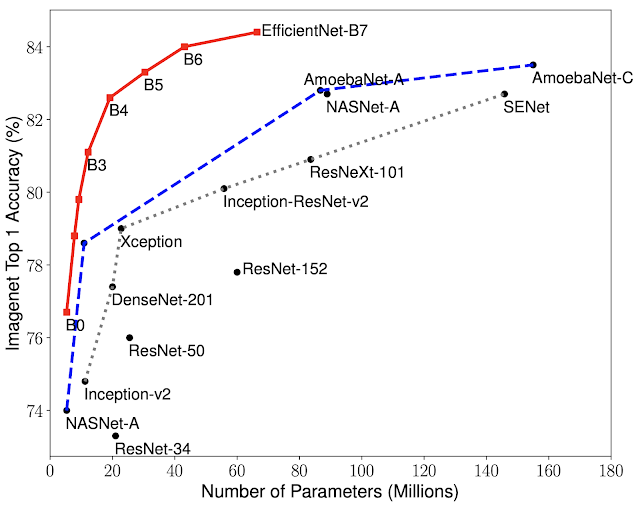

## Import Libraries

In [ ]:
!pip install pywavelets


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pywt
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split

## Wavelets

In [ ]:
wavelist = pywt.wavelist(kind='continuous')
print(wavelist)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


## Prepare Data

In [ ]:
!unzip /content/BonnDataset.zip

In [ ]:
!pip install tqdm

import os
from tqdm import tqdm


DATA_DIR_A = '/content/Z/'
DATA_DIR_B = '/content/O/'
DATA_DIR_C = '/content/N/'
DATA_DIR_D = '/content/F/'
DATA_DIR_E = '/content/S/'

LABEL_A = 0
LABEL_B = 1
LABEL_C = 2



def load_data():
    data = []
    nbFiles = 0
    for fname in tqdm(os.listdir(DATA_DIR_A)):
        img = np.loadtxt(DATA_DIR_A + fname)
        data.append([img, np.array(LABEL_A)])
        nbFiles+=1

    for fname in tqdm(os.listdir(DATA_DIR_B)):
       img = np.loadtxt(DATA_DIR_B + fname)
       data.append([img, np.array(LABEL_A)])
       nbFiles+=1

    for fname in tqdm(os.listdir(DATA_DIR_C)):
       img = np.loadtxt(DATA_DIR_C + fname)
       data.append([np.array(img), np.array(LABEL_B)])
       nbFiles+=1

    for fname in tqdm(os.listdir(DATA_DIR_D)):
       img = np.loadtxt(DATA_DIR_D + fname)
       data.append([np.array(img), np.array(LABEL_B)])
       nbFiles+=1

    for fname in tqdm(os.listdir(DATA_DIR_E)):
        img = np.loadtxt(DATA_DIR_E + fname)
        data.append([np.array(img), np.array(LABEL_C)])
        nbFiles+=1

    return data


data = load_data()
print(len(data), "Files")

100%|██████████| 100/100 [00:00<00:00, 956.24it/s]

500 Files


In [ ]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = np.array([d[0] for d in data_train])
Y_train = np.array([d[1] for d in data_train])

X_test = np.array([d[0] for d in data_test])
Y_test = np.array([d[1] for d in data_test])

X_train = X_train.reshape(X_train.shape[0], 4097, 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)

X_test = X_test.reshape(X_test.shape[0], 4097, 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

print(X_train.shape)

(400, 4097, 1)


In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(400, 4097, 1)
(400, 1)
(100, 4097, 1)
(100, 1)


In [ ]:
X_train

array([[[-148.],
        [-155.],
        [-156.],
        ...,
        [ -81.],
        [ -77.],
        [  95.]],

       [[-476.],
        [-518.],
        [-521.],
        ...,
        [ 246.],
        [ 556.],
        [ 276.]],

       [[  96.],
        [  43.],
        [  71.],
        ...,
        [  51.],
        [  90.],
        [ -28.]],

       ...,

       [[ -37.],
        [ -41.],
        [ -46.],
        ...,
        [ -29.],
        [ -33.],
        [ -51.]],

       [[-635.],
        [-573.],
        [-525.],
        ...,
        [-370.],
        [-415.],
        [-593.]],

       [[  23.],
        [  20.],
        [  -5.],
        ...,
        [ 225.],
        [ 181.],
        [  79.]]])

Data shapes:
X_train: (400, 4097, 1)
Y_train: (400, 1)
X_test: (100, 4097, 1)
Y_test: (100, 1)

#  Pretrained Network with CWT Scalograms


## Plot Scalograms

### Choose one of the following:

* 'morl' (Morlet)
* 'gaus1' (Gaussian 1)
* 'cmor' (Complex Morlet)
* 'cgau3' (Complex Gaussian 3)  
* 'cgau4' (Complex Gaussian 4)
* 'mexh' (Mexican Hat)
* 'shan' (Shannon)
* 'gaus4' (Gaussian 4)

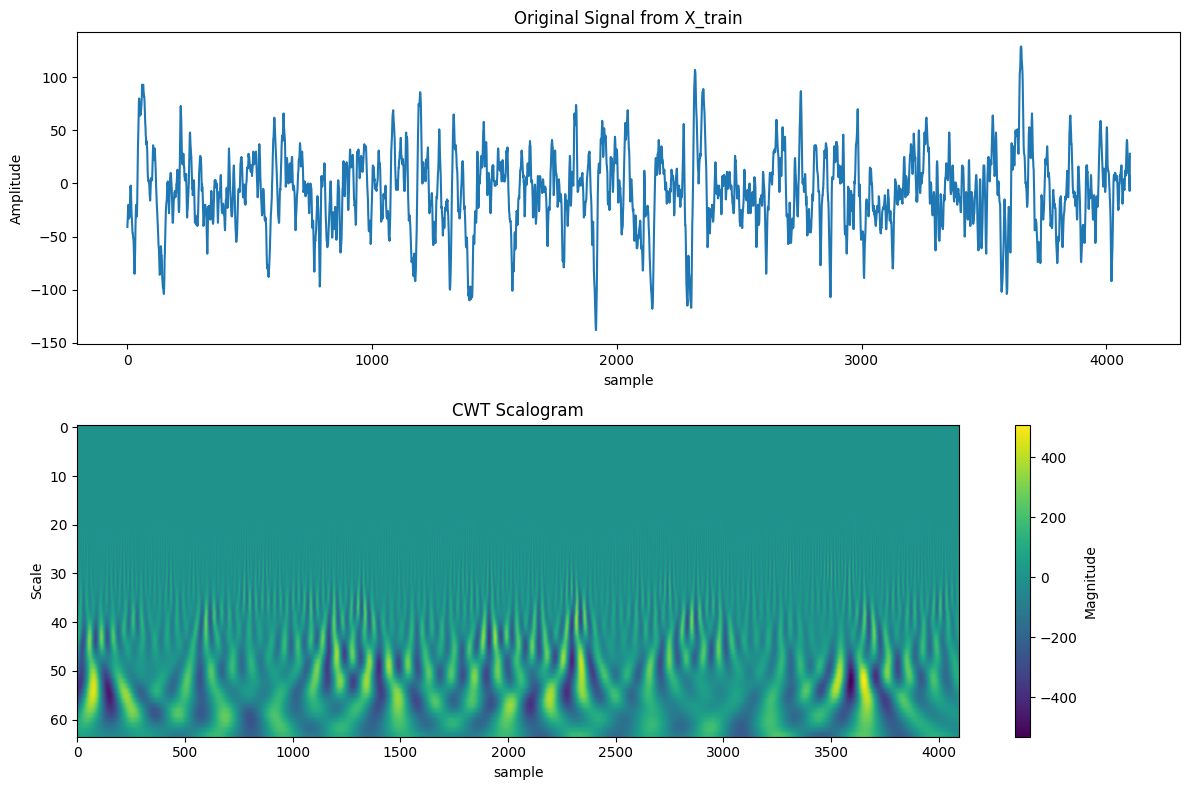

Original signal shape: (4097,)
CWT output shape: torch.Size([1, 64, 1, 4097])
CWT output min value: -530.9551
CWT output max value: 507.7641


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pywt
import matplotlib.pyplot as plt


class CWTLayer(nn.Module):
    def __init__(self, signal_length, wavelet='morl', num_scales=64):
        super(CWTLayer, self).__init__()
        self.signal_length = signal_length
        self.wavelet = wavelet
        self.num_scales = num_scales
        scales = torch.tensor(np.geomspace(1, 256, num_scales), dtype=torch.float32)
        self.register_buffer('scales', scales)

    def forward(self, x):
        batch_size = x.shape[0]
        cwt_list = []
        for i in range(batch_size):
            signal = x[i].detach().cpu().numpy()
            coef, _ = pywt.cwt(signal, self.scales.cpu().numpy(), self.wavelet)
            if self.wavelet.startswith('c'):  # complex wavelet
                coef = np.abs(coef)
            cwt_list.append(torch.from_numpy(coef).float())
        cwt_tensor = torch.stack(cwt_list).to(x.device)
        return cwt_tensor

def visualize_cwt(signal, cwt_output):
    plt.figure(figsize=(12, 8))


    plt.subplot(211)
    plt.plot(signal)
    plt.title('Original Signal from X_train')
    plt.xlabel('sample')
    plt.ylabel('Amplitude')


    plt.subplot(212)
    plt.imshow(cwt_output.squeeze().numpy(), aspect='auto', cmap='viridis')
    plt.title('CWT Scalogram')
    plt.xlabel('sample')
    plt.ylabel('Scale')
    plt.colorbar(label='Magnitude')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":


    signal_index = 0
    signal = X_train[signal_index].squeeze()


    if not isinstance(signal, np.ndarray):
        signal = signal.numpy()


    cwt_layer = CWTLayer(signal_length=len(signal))


    input_signal = torch.from_numpy(signal).float().unsqueeze(0).unsqueeze(0)


    with torch.no_grad():
        cwt_output = cwt_layer(input_signal)


    visualize_cwt(signal, cwt_output)

    print(f"Original signal shape: {signal.shape}")
    print(f"CWT output shape: {cwt_output.shape}")
    print(f"CWT output min value: {cwt_output.min().item():.4f}")
    print(f"CWT output max value: {cwt_output.max().item():.4f}")

# CWT Network (Select the Wavelet Here)
### Choose one of the following:

* 'morl' (Morlet)
* 'gaus1' (Gaussian 1)
* 'cmor' (Complex Morlet)
* 'cgau3' (Complex Gaussian 3)  
* 'cgau4' (Complex Gaussian 4)
* 'mexh' (Mexican Hat)
* 'shan' (Shannon)
* 'gaus4' (Gaussian 4)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import pywt
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.metrics import specificity_score, sensitivity_score
import seaborn as sns
import pandas as pd

# Edit This
class CWTLayer(nn.Module):
    def __init__(self, signal_length, wavelet='morl', num_scales=64):
        super(CWTLayer, self).__init__()
        self.signal_length = signal_length
        self.wavelet = wavelet
        self.num_scales = num_scales
        scales = torch.tensor(np.geomspace(1, 256, num_scales), dtype=torch.float32)
        self.register_buffer('scales', scales)
    def forward(self, x):
        batch_size = x.shape[0]
        cwt_list = []
        for i in range(batch_size):
            signal = x[i].detach().cpu().numpy()
            coef, _ = pywt.cwt(signal, self.scales.cpu().numpy(), self.wavelet)
            if self.wavelet.startswith('c'):  # complex wavelet
                coef = np.abs(coef)
            coef_norm = (coef - np.min(coef)) / (np.max(coef) - np.min(coef) + 1e-8)
            rgb_scalogram = cm.viridis(coef_norm)[:, :, :3]

            cwt_list.append(torch.from_numpy(rgb_scalogram).float().permute(2, 0, 1))

        cwt_tensor = torch.stack(cwt_list).to(x.device)
        return cwt_tensor

class CWTNetwork(nn.Module):
    def __init__(self, input_length=4097, num_classes=5):
        super(CWTNetwork, self).__init__()
        self.conv1d = nn.Conv1d(1, 1, kernel_size=5, stride=2)
        self.cwt = CWTLayer(signal_length=input_length // 2)

        self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        x = x.squeeze(-1)
        x = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-8)
        x = x.unsqueeze(1)
        x = self.conv1d(x)
        x = self.cwt(x.squeeze(1))
        x = self.efficientnet(x)
        return x

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def prepare_data_with_split(X, Y, batch_size=32, val_split=0.2, test_split=0.1, random_state=42):
    """
    Prepare data with train/validation/test splits
    """
    torch.manual_seed(random_state)
    X_tensor = torch.FloatTensor(X)
    Y_tensor = torch.LongTensor(Y.squeeze())

    dataset = TensorDataset(X_tensor, Y_tensor)
    test_size = int(test_split * len(dataset))
    val_size = int(val_split * len(dataset))
    train_size = len(dataset) - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def prepare_cross_validation_data(X, Y, n_folds=5, batch_size=32, random_state=42):
    """
    Prepare data for k-fold cross-validation
    """
    torch.manual_seed(random_state)
    np.random.seed(random_state)

    X_tensor = torch.FloatTensor(X)
    Y_tensor = torch.LongTensor(Y.squeeze())

    dataset = TensorDataset(X_tensor, Y_tensor)

    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    fold_data = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        fold_data.append((train_loader, val_loader))

    return fold_data

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
                                    num_epochs=50, patience=7, device='cuda'):
    """
    Train model with early stopping based on validation loss
    """
    model.to(device)
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_model.pth')

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_train_loss)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device, mode='val')
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.2f}%')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break
    model.load_state_dict(torch.load('best_model.pth'))

    return model, history

def evaluate_model(model, data_loader, criterion=None, device='cuda', mode='val'):
    """
    Evaluate model on the provided data loader
    mode: 'val' for validation metrics, 'test' for detailed test metrics
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100

    if mode == 'val':
        # For validation, just return basic metrics
        if criterion is not None:
            return running_loss / len(data_loader), accuracy
        else:
            return accuracy
    else:
        # For test, calculate and return detailed metrics
        precision = precision_score(all_labels, all_preds, average='macro') * 100
        sensitivity = sensitivity_score(all_labels, all_preds, average='macro') * 100
        f1 = f1_score(all_labels, all_preds, average='macro') * 100
        specificity = specificity_score(all_labels, all_preds, average='macro') * 100
        cm = confusion_matrix(all_labels, all_preds)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'f1_score': f1,
            'confusion_matrix': cm,
            'class_labels': np.unique(all_labels),
            'predictions': all_preds,
            'true_labels': all_labels
        }

        return metrics

def plot_confusion_matrix(cm, class_names):
    """
    Plot confusion matrix
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.SVG')
    plt.show()

def plot_training_history(history):
    """
    Plot training history
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.SVG')
    plt.show()

In [ ]:
def main(X_train, Y_train, X_test=None, Y_test=None, use_cross_validation=True):
    """
    Main function to run the EEG classification pipeline
    """
    input_length = 4097
    num_classes = 3
    learning_rate = 0.001
    batch_size = 32
    num_epochs = 25
    patience = 7
    n_folds = 5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if X_test is None or Y_test is None or use_cross_validation:
        print("Using k-fold cross-validation...")

        fold_data = prepare_cross_validation_data(X_train, Y_train, n_folds=n_folds, batch_size=batch_size)
        fold_accuracies = []
        fold_metrics = []

        for fold, (train_loader, val_loader) in enumerate(fold_data):
            print(f"\nTraining fold {fold+1}/{n_folds}")

            model = CWTNetwork(input_length=input_length, num_classes=num_classes)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Train model
            model, history = train_model_with_early_stopping(
                model, train_loader, val_loader, criterion, optimizer,
                num_epochs=num_epochs, patience=patience, device=device
            )

            # Evaluate on validation set
            val_metrics = evaluate_model(model, val_loader, criterion, device, mode='test')
            fold_accuracies.append(val_metrics['accuracy'])
            fold_metrics.append(val_metrics)

            print(f"Fold {fold+1} Results:")
            print(f"Accuracy: {val_metrics['accuracy']:.2f}%")
            print(f"Precision: {val_metrics['precision']:.2f}%")
            print(f"Recall/Sensitivity: {val_metrics['sensitivity']:.2f}%")
            print(f"Specificity: {val_metrics['specificity']:.2f}%")
            print(f"F1 Score: {val_metrics['f1_score']:.2f}%")

            plt.figure(figsize=(8, 6))
            sns.heatmap(val_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - Fold {fold+1}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.savefig(f'confusion_matrix_fold_{fold+1}.png')
            plt.close()

            plot_training_history(history)

        avg_accuracy = np.mean([m['accuracy'] for m in fold_metrics])
        avg_precision = np.mean([m['precision'] for m in fold_metrics])
        avg_recall = np.mean([m['sensitivity'] for m in fold_metrics])
        avg_specificity = np.mean([m['specificity'] for m in fold_metrics])
        avg_f1 = np.mean([m['f1_score'] for m in fold_metrics])

        print("\nAverage Cross-Validation Results:")
        print(f"Accuracy: {avg_accuracy:.2f}% ± {np.std(fold_accuracies):.2f}%")
        print(f"Precision: {avg_precision:.2f}%")
        print(f"Recall/Sensitivity: {avg_recall:.2f}%")
        print(f"Specificity: {avg_specificity:.2f}%")
        print(f"F1 Score: {avg_f1:.2f}%")

    else:
        print("Using train/validation/test split...")

        train_loader, val_loader, test_loader = prepare_data_with_split(
            X_train, Y_train, batch_size=batch_size, val_split=0.2, test_split=0
        )

        test_X_tensor = torch.FloatTensor(X_test)
        test_Y_tensor = torch.LongTensor(Y_test.squeeze())
        test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        model = CWTNetwork(input_length=input_length, num_classes=num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        model, history = train_model_with_early_stopping(
            model, train_loader, val_loader, criterion, optimizer,
            num_epochs=num_epochs, patience=patience, device=device
        )

        plot_training_history(history)

        print("\nEvaluating on test set...")
        test_metrics = evaluate_model(model, test_loader, device=device, mode='test')

        print("Test Results:")
        print(f"Accuracy: {test_metrics['accuracy']:.2f}%")
        print(f"Precision: {test_metrics['precision']:.2f}%")
        print(f"Recall/Sensitivity: {test_metrics['sensitivity']:.2f}%")
        print(f"Specificity: {test_metrics['specificity']:.2f}%")
        print(f"F1 Score: {test_metrics['f1_score']:.2f}%")

        class_names = [f'{chr(65 + i)}' for i in range(num_classes)]
        plot_confusion_matrix(test_metrics['confusion_matrix'], class_names)

        torch.save(model.state_dict(), 'final_model.pth')
        print("Final model saved to 'final_model.pth'")

## Train using Test Set

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Data shapes:
X_train: (400, 4097, 1)
Y_train: (400, 1)
X_test: (100, 4097, 1)
Y_test: (100, 1)
Using device: cuda
Using train/validation/test split...


100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]


Epoch 1/25, Train Loss: 0.4034, Val Loss: 1.0706, Val Accuracy: 52.50%
Validation loss decreased (inf --> 1.070646). Saving model...
Epoch 2/25, Train Loss: 0.2004, Val Loss: 0.8117, Val Accuracy: 70.00%
Validation loss decreased (1.070646 --> 0.811738). Saving model...
Epoch 3/25, Train Loss: 0.0960, Val Loss: 3.1037, Val Accuracy: 42.50%
EarlyStopping counter: 1 out of 7
Epoch 4/25, Train Loss: 0.0693, Val Loss: 2.3323, Val Accuracy: 51.25%
EarlyStopping counter: 2 out of 7
Epoch 5/25, Train Loss: 0.0701, Val Loss: 0.3752, Val Accuracy: 88.75%
Validation loss decreased (0.811738 --> 0.375230). Saving model...
Epoch 6/25, Train Loss: 0.0439, Val Loss: 0.0345, Val Accuracy: 98.75%
Validation loss decreased (0.375230 --> 0.034475). Saving model...
Epoch 7/25, Train Loss: 0.0535, Val Loss: 0.0869, Val Accuracy: 98.75%
EarlyStopping counter: 1 out of 7
Epoch 8/25, Train Loss: 0.0275, Val Loss: 0.0549, Val Accuracy: 96.25%
EarlyStopping counter: 2 out of 7
Epoch 9/25, Train Loss: 0.0785, V

<ipython-input-12-c0028f26c8ef>:192: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


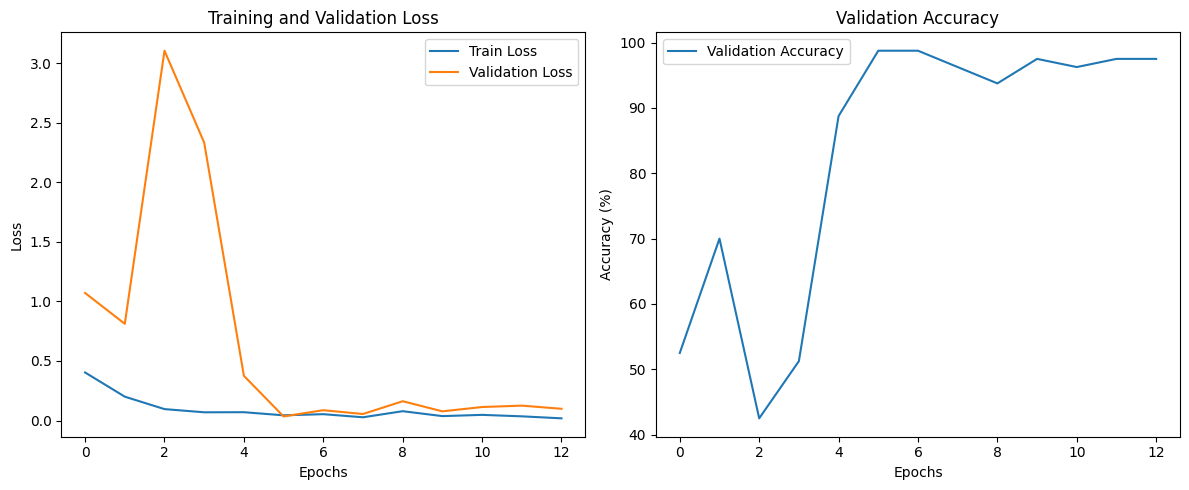


Evaluating on test set...
Test Results:
Accuracy: 99.00%
Precision: 99.05%
Recall/Sensitivity: 99.21%
Specificity: 99.49%
F1 Score: 99.12%


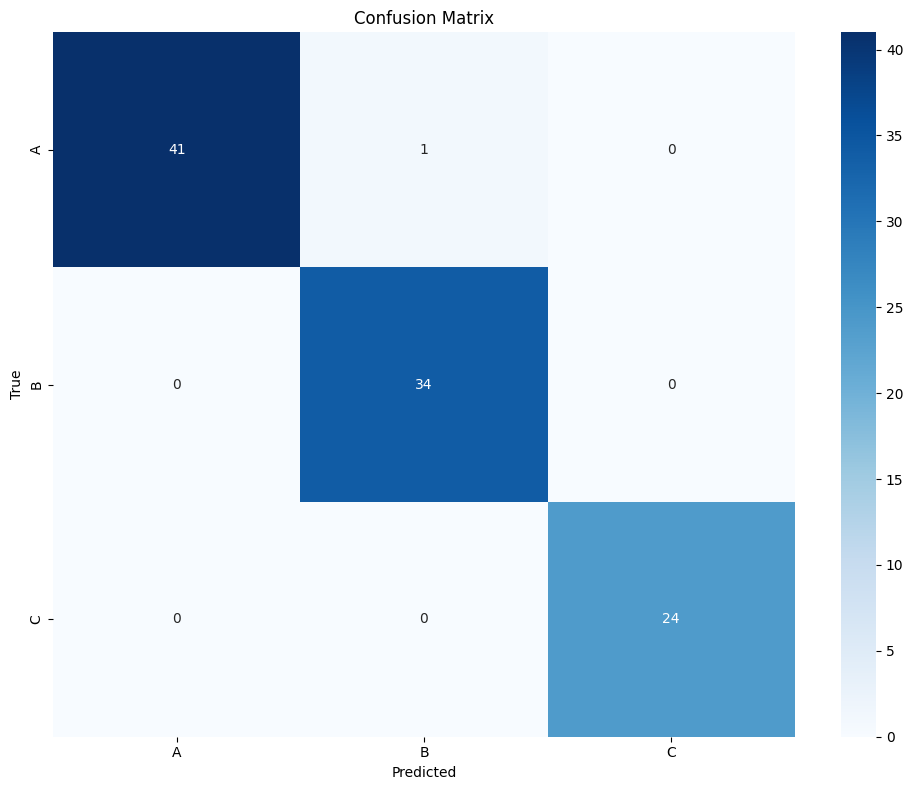

Final model saved to 'final_model.pth'


In [ ]:
print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

main(X_train, Y_train, X_test, Y_test, use_cross_validation=False)

## Train using K-fold (Do not run This!)

In [ ]:
print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")

main(X_train, Y_train, use_cross_validation=True)